## Imports and Loading Data

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
df = pd.read_excel('Data Model - Pizza Sales.xlsx')
df.head()

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [22]:
len(df)

48620

In [4]:
by_days = df.groupby(by = 'order_date')['total_price'].sum()

In [9]:
by_days

order_date
2015-01-01    2713.85
2015-01-02    2731.90
2015-01-03    2662.40
2015-01-04    1755.45
2015-01-05    2065.95
               ...   
2015-12-27    1419.00
2015-12-28    1637.20
2015-12-29    1353.25
2015-12-30    1337.80
2015-12-31    2916.00
Name: total_price, Length: 358, dtype: float64

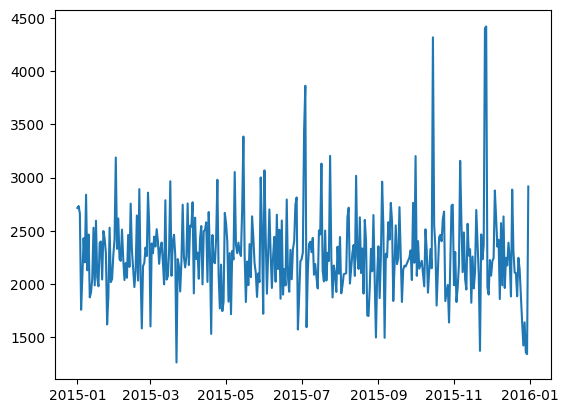

In [10]:
plt.plot(by_days)
plt.show()

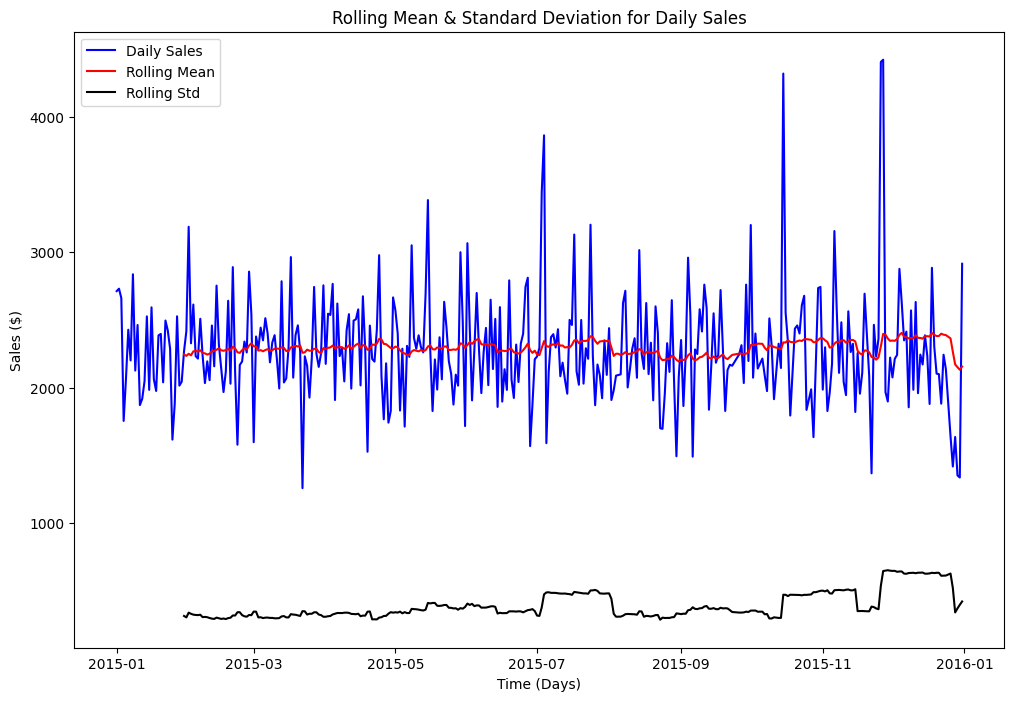

In [9]:
# View temperature data, its mean, and its standard deviation over time
rolmean = by_days.rolling(window = 30).mean()
rolstd = by_days.rolling(window = 30).std()

fig = plt.figure(figsize=(12, 8))
orig = plt.plot(by_days, color='blue',label='Daily Sales')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation for Daily Sales')
plt.xlabel('Time (Days)')
plt.ylabel('Sales ($)')
plt.show()

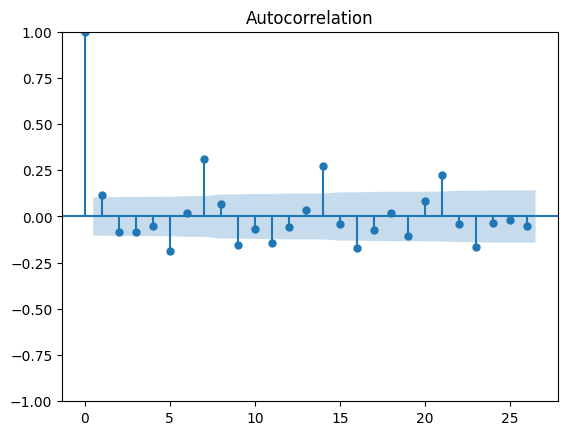

In [21]:
# Autocorrelation for data downsampled to daily
plot_acf(by_days)
plt.show()

<Figure size 640x480 with 0 Axes>

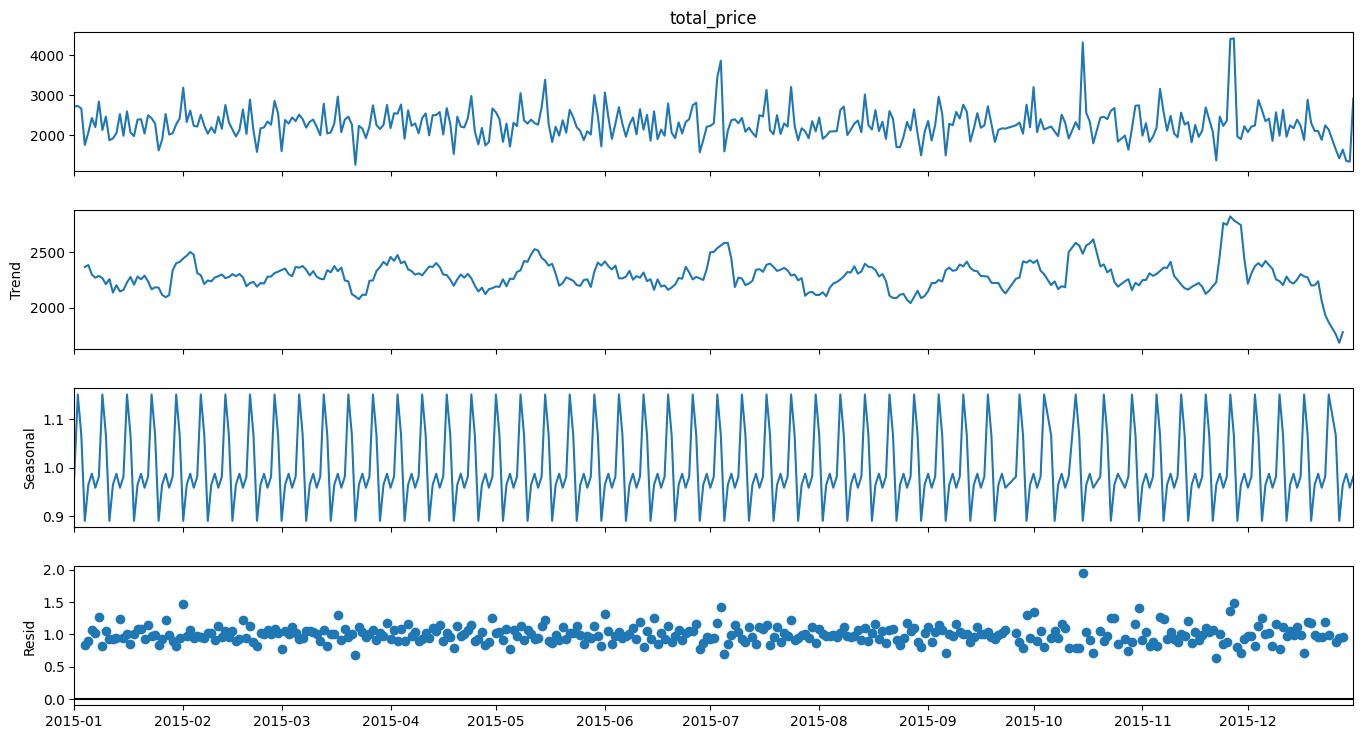

In [54]:
# Apply seasonal decomposition
result = seasonal_decompose(by_days, model='multiplicative', period = 7) # Use 'multiplicative' for multiplicative model

# # You can then access the individual components
# trend = result.trend
# seasonal = result.seasonal
residual = result.resid

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 8)
plt.show()

order_date
2015-01-01         NaN
2015-01-02         NaN
2015-01-03         NaN
2015-01-04    0.834084
2015-01-05    0.898611
                ...   
2015-12-27    0.948452
2015-12-28    0.954816
2015-12-29         NaN
2015-12-30         NaN
2015-12-31         NaN
Name: resid, Length: 358, dtype: float64

In [24]:
# Join date and time columns for combined datetime column
df['complete_order_date'] = pd.to_datetime(df['order_date'].astype(str)+' '+df['order_time'].astype(str))

In [38]:
# Create hourly downsampled sales from complete datetime column
hourly_sales = df[['complete_order_date', 'total_price']]
hourly_sales.set_index('complete_order_date', inplace = True)
hourly_sales = hourly_sales.resample('1H').sum()

In [39]:
hourly_sales

,total_price
complete_order_date,
2015-01-01 11:00:00,105.25
2015-01-01 12:00:00,263.25
2015-01-01 13:00:00,577.20
2015-01-01 14:00:00,246.00
2015-01-01 15:00:00,230.25
...,...
2015-12-31 19:00:00,396.15
2015-12-31 20:00:00,278.50
2015-12-31 21:00:00,113.20


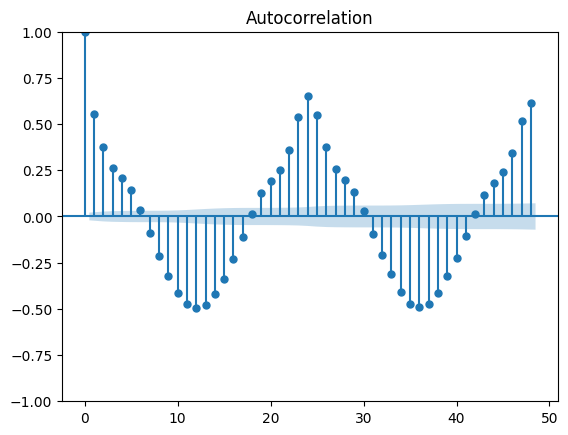

In [45]:
# Autocorrelation for data downsampled to daily
plot_acf(hourly_sales, lags = 48)
plt.show()

<Figure size 640x480 with 0 Axes>

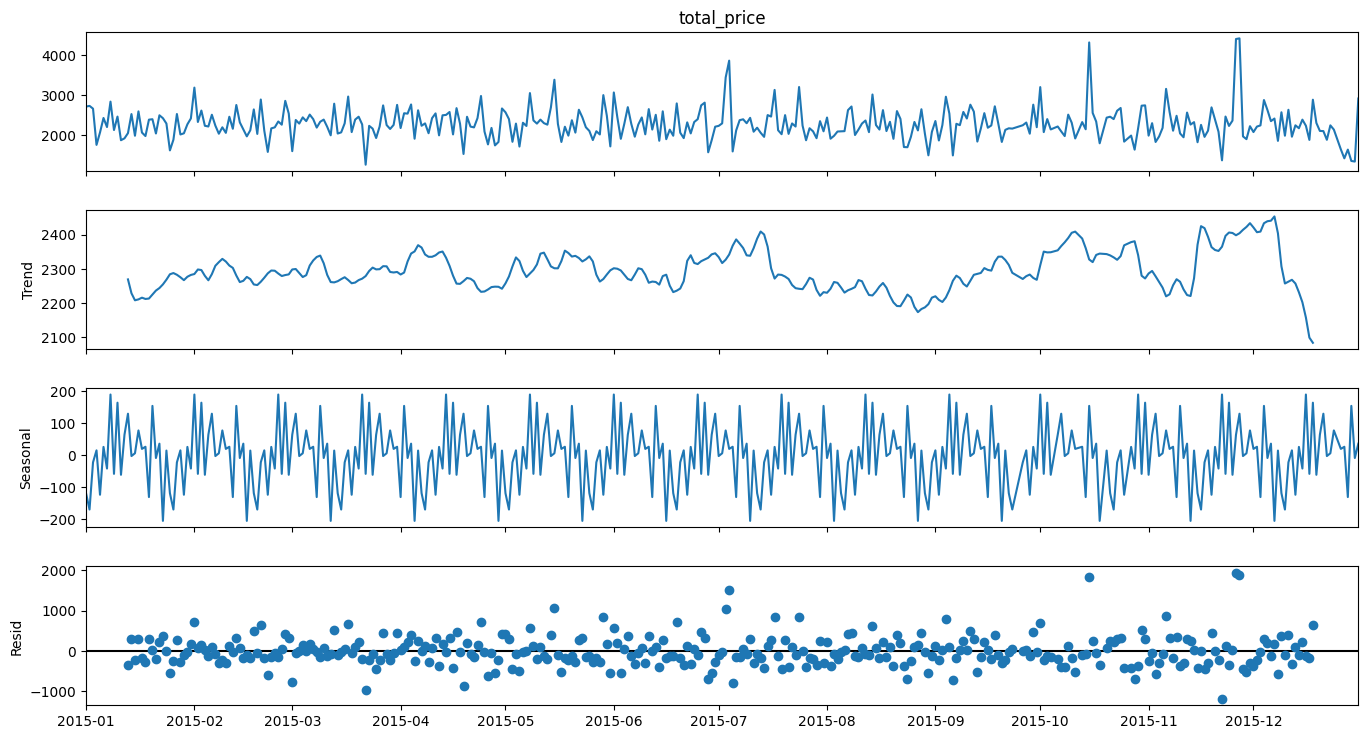

In [50]:
# Apply seasonal decomposition
result = seasonal_decompose(by_days, model='additive') # Use 'multiplicative' for multiplicative model

# # You can then access the individual components
# trend = result.trend
# seasonal = result.seasonal
# residual = result.resid

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 8)
plt.show()

In [3]:
df.isna().sum()

order_details_id     0
order_id             0
pizza_id             0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

In [4]:
df.dtypes

order_details_id              int64
order_id                      int64
pizza_id                     object
quantity                      int64
order_date           datetime64[ns]
order_time                   object
unit_price                  float64
total_price                 float64
pizza_size                   object
pizza_category               object
pizza_ingredients            object
pizza_name                   object
dtype: object

## Explore Data to Generate New Menu

We'd like to generate a new menu by resampling this menu's unit_price column and drawing from its theoretical population. The strategy is this: 

1) Explore data to find an array of unique item's prices. Consider the fact that some items may have the same price as others. Therefore, the resulting unit_price array may have duplicate prices in it. However, each unique item (pepperoni pizza, veggie pizza, etc.) will have its price represented. 
2) Treat this array of menu prices as a sample from a population of menu prices. Bootstrap (sample with replacement) from this sample to generate many new samples.
3) Take descriptive statistics of these samples to create a sampling distribution of menu prices.
4) Take advantage of the Central Limit Theorem and use the normal distibution to generate a new array of menu prices using the "true" population mean and "true" standard deviation from the sampling distributions we built in step three.

### Step 1: Find List of Prices for Each Unique Menu Item

In [8]:
df['pizza_id'].value_counts()

pizza_id
big_meat_s        1811
thai_ckn_l        1365
five_cheese_l     1359
four_cheese_l     1273
classic_dlx_m     1159
                  ... 
mexicana_s         160
calabrese_s         99
ckn_alfredo_s       96
green_garden_l      94
the_greek_xxl       28
Name: count, Length: 91, dtype: int64

In [9]:
# There are 91 unique menu items
unique_menu_items = df['pizza_id'].unique()
len(unique_menu_items)

91

In [18]:
# Group by pizza_id and unit_price to get dataframe of each unique item mapped to their unique price
unique_menu_items_w_prices = df[['pizza_id', 'unit_price']].groupby(by = ['pizza_id', 'unit_price'], as_index = False).count()
unique_menu_items_w_prices

,pizza_id,unit_price
0,bbq_ckn_l,20.75
1,bbq_ckn_m,16.75
2,bbq_ckn_s,12.75
3,big_meat_s,12.00
4,brie_carre_s,23.65
...,...,...
86,the_greek_xl,25.50
87,the_greek_xxl,35.95
88,veggie_veg_l,20.25
89,veggie_veg_m,16.00


In [21]:
# Make sure no unique item somehow sells for two different prices by comparing the length of the unique list of pizza_id's with the unit_price column from the above groupedby object3
# If they are not the same length then there is a pizza_id with more than one unit_price
len(unique_menu_items_w_prices['unit_price']) == len(unique_menu_items_w_prices['pizza_id'].unique())

True

In [24]:
# Store list of prices. It is from this list we will bootstrap.
seed_menu_prices = unique_menu_items_w_prices['unit_price']

### Step 2: Bootstrapping

In [25]:
bootstrapped_samples = [] # Initialize empty list to hold samples. List of lists. 

# Generate 10,000 samples by sampling with replacement from the seed_menu_prices list
# Each new sample will be of the same length as the original seed sample, i.e. each new menu will have 91 items on it
for sample in range(10000):
    x = seed_menu_prices.sample(n = len(seed_menu_prices), replace = True)
    bootstrapped_samples.append(x)

### Step 3: Take Descriptive Statistics of Bootstrapped Samples

In [26]:
sample_dist_means = [] # Initialize empty list to hold means of bootstrapped samples

# Take the mean of each sample and store it to build sampling distribution
for sample in bootstrapped_samples:
    sample_dist_means.append(sample.mean())

In [27]:
# Do the same as above for standard deviations
sample_dist_stds = []
for sample in bootstrapped_samples:
    sample_dist_stds.append(sample.std())

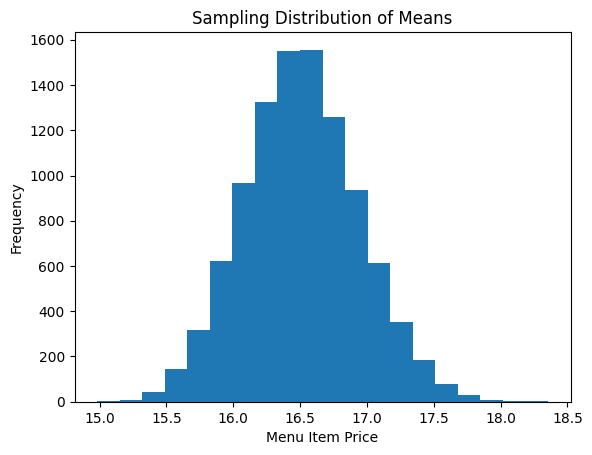

In [29]:
# As per the Central Limit Theorem, regardless of the shape of the samples, the sampling distribution will be approximately normal and centered on the population's parameters
plt.hist(x = sample_dist_means, bins  = 20)
plt.title('Sampling Distribution of Means')
plt.xlabel('Means in Dollar Amount')
plt.ylabel('Frequency')
plt.show()

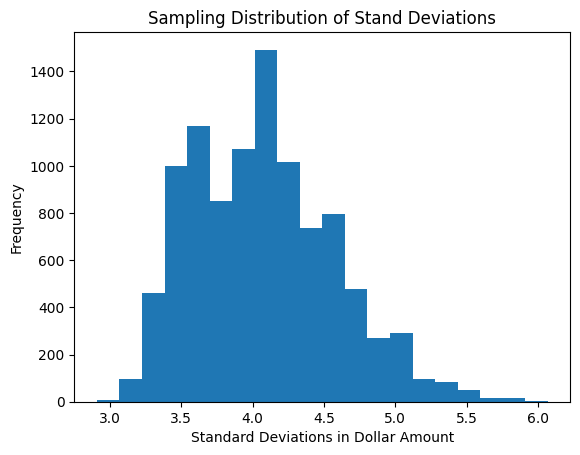

In [30]:
plt.hist(x = sample_dist_stds, bins  = 20)
plt.title('Sampling Distribution of Stand Deviations')
plt.xlabel('Standard Deviations in Dollar Amount')
plt.ylabel('Frequency')
plt.show()

### Step 4: Generate New Menu Prices via Normal Distribution

In [31]:
simulated_menu = np.random.normal(loc = np.mean(sample_dist_means), scale = np.mean(sample_dist_stds), size = len(seed_menu_prices))

In [33]:
simulated_menu = np.around(simulated_menu, decimals = 2)
simulated_menu

array([15.93, 17.86, 22.35, 20.06, 16.44, 11.38, 14.53, 16.26, 14.84,
       17.47, 19.92, 21.43, 16.93, 22.43, 24.58, 15.03, 12.69, 15.1 ,
       25.79, 15.28, 18.65, 12.68,  7.39, 13.67, 10.8 ,  7.  , 10.33,
       19.76, 12.  , 14.57, 13.67, 20.4 , 15.1 , 14.06, 12.73, 13.79,
       12.13,  9.14, 11.91, 18.07, 11.24, 12.44, 16.31, 14.72, 16.07,
       11.52, 11.74, 19.65, 19.37, 18.  ,  5.99, 14.5 , 17.42, 17.27,
       15.29, 17.81, 14.05, 15.53, 16.21, 14.71, 19.8 , 13.73, 15.98,
       12.91, 16.65, 20.43, 16.11, 18.47, 20.31, 17.57,  8.42, 15.6 ,
       18.52, 13.43, 16.83, 18.13, 14.73, 15.93, 15.42, 14.21, 14.96,
       14.62, 17.85, 16.26, 19.66, 13.59, 19.86, 10.94, 20.48, 18.36,
       12.81])

In [42]:
type(simulated_menu), type(seed_menu_prices)

(numpy.ndarray, pandas.core.series.Series)

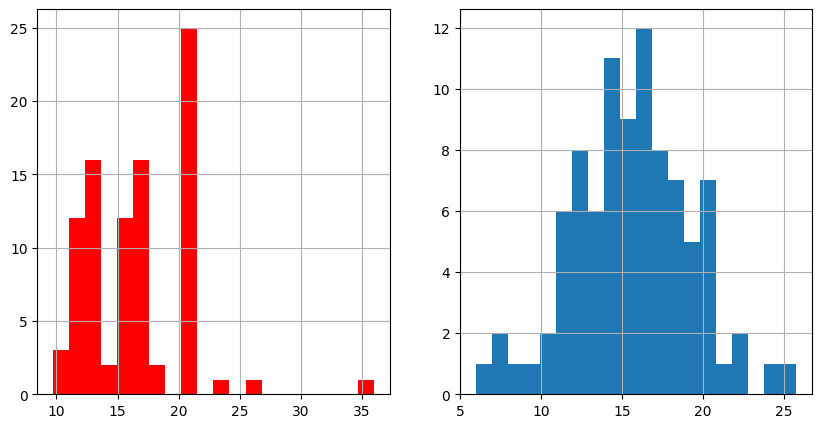

In [48]:
fig, axes = plt.subplots(1, 2)

fig.set_size_inches(10, 5)
seed_menu_prices.hist(bins=20, ax=axes[0], color = 'r')
pd.Series(simulated_menu).hist(bins=20, ax=axes[1])
plt.show()

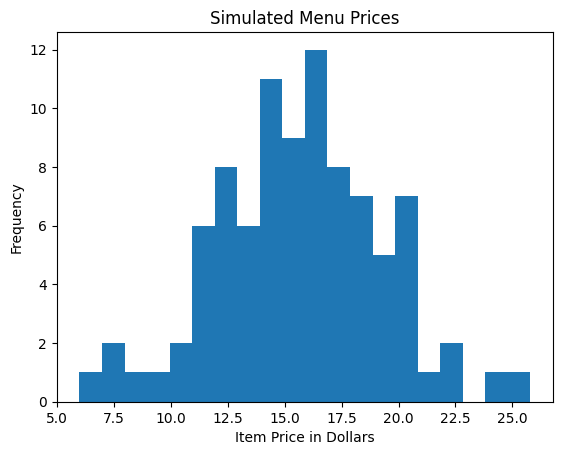

In [36]:
plt.hist(x = simulated_menu, bins = 20)
plt.title('Simulated Menu Prices')
plt.xlabel('Item Price in Dollars')
plt.ylabel('Frequency')
plt.show()

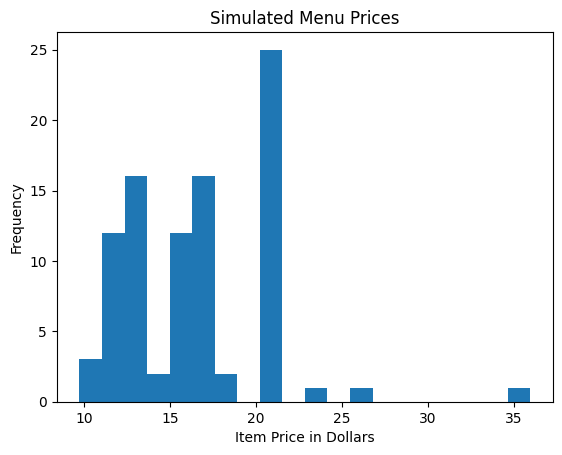

In [37]:
plt.hist(x = seed_menu_prices, bins = 20)
plt.title('Simulated Menu Prices')
plt.xlabel('Item Price in Dollars')
plt.ylabel('Frequency')
plt.show()

In [49]:
seed_menu_prices.mean(), simulated_menu.mean()

(16.506043956043957, 15.676483516483513)

In [50]:
seed_menu_prices.std(), simulated_menu.std()

(4.128356110587382, 3.668382094981824)

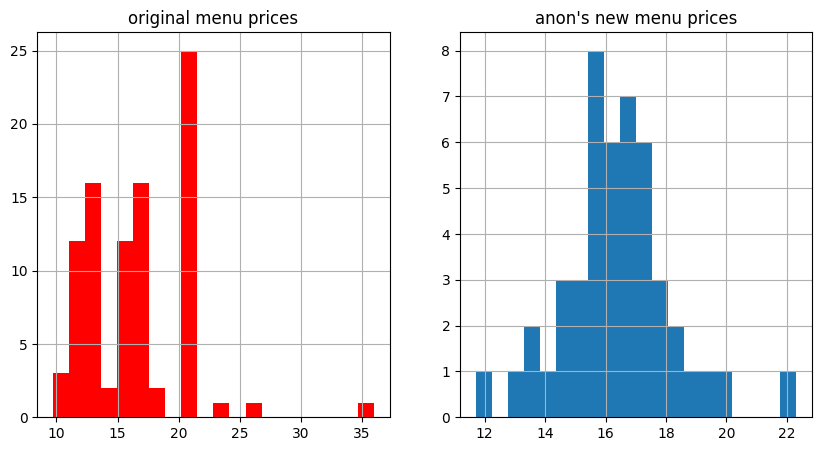

In [56]:
number_of_items = np.random.randint(40, 80)
prices = np.random.normal(loc = seed_menu_prices.mean(), scale = seed_menu_prices.mean() / 10, size = number_of_items)

fig, axes = plt.subplots(1, 2)

fig.set_size_inches(10, 5)
seed_menu_prices.hist(bins=20, ax=axes[0], color = 'r')
axes[0].title.set_text('original menu prices')
pd.Series(prices).hist(bins=20, ax=axes[1])
axes[1].title.set_text("anon's new menu prices")
plt.show()